## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import math
%matplotlib inline

class CameraParams:
    mtx=[]
    dist=[]
    rvecs=[]
    tvecs=[]

## Calculation of the Distortion Correction Parameters

In [2]:
#calculate the distortion correction parameters
myCamParams = CameraParams()

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
gray_imgs = []
distorted = []
undistorted = []
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners

for fname in images:
    img = cv2.imread(fname)
    distorted.append(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray_imgs.append(gray)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_imgs[0].shape[::-1],None,None)

myCamParams.mtx = mtx
myCamParams.dist=dist
myCamParams.rvecs=rvecs
myCamParams.tvecs=tvecs

pickle_out = open("camParams.p","wb")
pickle.dump(myCamParams,pickle_out)
pickle_out.close()

for disted in distorted:
    undist = cv2.undistort(disted,mtx,dist,None,mtx)
    vis = np.concatenate((disted,undist),axis=1)
    cv2.imshow('undistorted',vis)
    cv2.waitKey(300)
    undistorted.append(vis)
    
cv2.destroyAllWindows()

In [3]:
img = cv2.imread("./camera_cal/calibration1.jpg")
corrected_img = cv2.undistort(img,myCamParams.mtx,myCamParams.dist,None,myCamParams.mtx)
cv2.imwrite('./output_images/undistorted_img.png',corrected_img)

True

## Building the Pipeline

### Checking undistortion

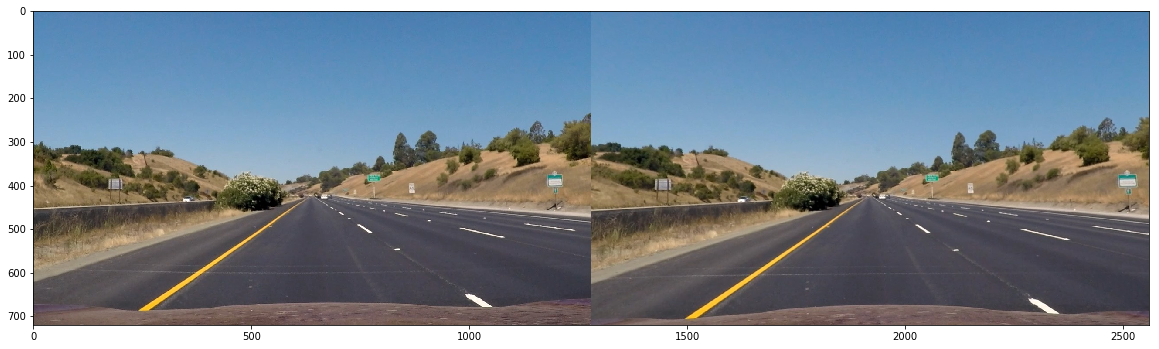

In [4]:
#restore camera parameters
params_file = open("camParams.p","rb")
camParams = pickle.load(params_file)
params_file.close()

#undistort the test image and visualize
img = cv2.imread("./test_images/straight_lines1.jpg")
#img = cv2.imread("./test_images/test6.jpg")
corrected_img = cv2.undistort(img,camParams.mtx,camParams.dist,None,camParams.mtx)
compare = np.concatenate((img,corrected_img),axis=1)
resized = cv2.resize(compare,(int(compare.shape[1]/2),int(compare.shape[0]/2)))
plt.figure(num=1,figsize=(20,20))
plt.imshow(cv2.cvtColor(compare,cv2.COLOR_BGR2RGB))
#cv2.imwrite('resized_img.png',resized)

### Perspective Transform

In [5]:
def warp(img,tMtx,inverse=False):
    flags = cv2.INTER_LINEAR +cv2.WARP_FILL_OUTLIERS
    if inverse:
        flags += cv2.WARP_INVERSE_MAP
    img_size=(img.shape[1],img.shape[0])
    return cv2.warpPerspective(img,tMtx,img_size,flags)

In [6]:
#from functions above and some fudging, determined source points to be
src = np.float32([[(200,720),(580,480),(720,480),(1050,700)]])
dst = np.float32([[(290,720),(400,190),(930,190),(960,720)]])
M = cv2.getPerspectiveTransform(src,dst)
M_inv = cv2.getPerspectiveTransform(dst,src)

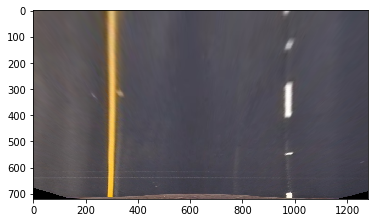

In [7]:
#masked_img = region_of_interest(corrected_img,np.int32(src))
#plt.imshow(cv2.cvtColor(masked_img,cv2.COLOR_BGR2RGB))
#img_size=(corrected_img.shape[1],corrected_img.shape[0])
warped = warp(corrected_img,M)
cv2.imwrite('./output_images/birdsEye.png',warped)
unwarped = warp(warped,M_inv,True)
plt.figure(num=1)
plt.imshow(cv2.cvtColor(warped,cv2.COLOR_BGR2RGB))
#plt.figure(num=2)
#plt.imshow(cv2.cvtColor(unwarped,cv2.COLOR_BGR2RGB))

### Thresholding

In [8]:
def abs_sobel_thresh(img, orient='x',sobel_kernel=3,thresh=(0,255),single_chan=True):
    if(single_chan):
        gray = img
    else:
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
    if(orient=='x'):
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if(orient=='y'):
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

In [9]:
def mag_thresh(img,sobel_kernel=3,mag_thresh=(0,255),single_chan=True):
    if(single_chan):
        gray = img
    else:
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    gradx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    grady = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    mag_grad = np.sqrt(np.square(gradx)+np.square(grady))
    scaled_mag_grad = np.uint8(255*mag_grad/np.max(mag_grad))
    sbinary = np.zeros_like(scaled_mag_grad)
    sbinary[(scaled_mag_grad >= mag_thresh[0]) & (scaled_mag_grad <= mag_thresh[1])] =1
    binary_output = sbinary
    
    return binary_output

In [10]:
def dir_threshold(img,sobel_kernel=3, thresh=(0, np.pi/2),single_chan=True):
    if(single_chan):
        gray = img
    else:
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

In [11]:
def binarize(img,thresh=(0,255)):
    binary = np.zeros_like(img)
    binary[(img >= thresh[0])&(img <= thresh[1])]=1
    return binary

In [12]:
def thresh_and_binary(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    hls = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    h_chan = hsv[:,:,0]
    s_chan = hsv[:,:,1]
    v_chan = hsv[:,:,2]
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    #initilize placeholder steps
    yellow_edge = np.zeros_like(h_chan)
    white_edge = np.zeros_like(h_chan)
    shadow = np.zeros_like(v_chan)
    two = np.zeros_like(h_chan)
    two_a = np.zeros_like(h_chan)
    two_b = np.zeros_like(h_chan)
    three = np.zeros_like(h_chan)
    four = np.zeros_like(h_chan)
    five = np.zeros_like(h_chan)
    white = np.zeros_like(h_chan)
    yellow = np.zeros_like(h_chan)
    sobelx = np.zeros_like(gray)
    sobely = np.zeros_like(gray)
    #process the image
    
    two = binarize(h_chan,(60,255))
    two_a = binarize(s_chan,(60,255))
    four[(two==1)&(two_a==1)]=1
    two_b = binarize(s,(100,255))
    sobelx = abs_sobel_thresh(gray,'x',3,(20,100))
    v_chan[(four==1)]=0
    s_chan[(four==1)]=0
    yellow_edge = abs_sobel_thresh(s_chan,'x',5,(20,100))
    white_edge = mag_thresh(v_chan,3,(200,255)) #mag_thresh(h_chan,3,(200,250))
    white = binarize(v_chan,(200,255))
    yellow = binarize(s_chan,(120,220))
    five=binarize(v_chan,(180,190))
    
    shadow =binarize(v_chan,(0,60))
    three[(white == 1)&(two_b==1) |( (yellow==1)&(yellow_edge==0))|(sobelx==1)]=1
    
    
    return three #binary image

In [13]:
def thresh_and_binary_RGB(img):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    h_chan = hsv[:,:,0]
    s_chan = hsv[:,:,1]
    v_chan = hsv[:,:,2]
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    #initilize placeholder steps
    yellow_edge = np.zeros_like(h_chan)
    white_edge = np.zeros_like(h_chan)
    shadow = np.zeros_like(v_chan)
    two = np.zeros_like(h_chan)
    two_a = np.zeros_like(h_chan)
    two_b = np.zeros_like(h_chan)
    three = np.zeros_like(h_chan)
    four = np.zeros_like(h_chan)
    five = np.zeros_like(h_chan)
    white = np.zeros_like(h_chan)
    yellow = np.zeros_like(h_chan)
    sobelx = np.zeros_like(gray)
    sobely = np.zeros_like(gray)
    #process the image
    
    two = binarize(h_chan,(60,255))
    two_a = binarize(s_chan,(60,255))
    four[(two==1)&(two_a==1)]=1
    two_b = binarize(s,(100,255))
    sobelx = abs_sobel_thresh(gray,'x',3,(20,100))
    v_chan[(four==1)]=0
    s_chan[(four==1)]=0
    yellow_edge = abs_sobel_thresh(s_chan,'x',5,(20,100))
    white_edge = mag_thresh(v_chan,3,(200,255)) #mag_thresh(h_chan,3,(200,250))
    white = binarize(v_chan,(200,255))
    yellow = binarize(s_chan,(120,220))
    five=binarize(v_chan,(180,190))
    
    shadow =binarize(v_chan,(0,60))
    three[(white == 1)&(two_b==1) |( (yellow==1)&(yellow_edge==0))|(sobelx==1)]=1
    
    
    return three #binary image

In [14]:
def test_thresh(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    hls = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    h_chan = hsv[:,:,0]
    s_chan = hsv[:,:,1]
    v_chan = hsv[:,:,2]
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    #initilize placeholder steps
    yellow_edge = np.zeros_like(h_chan)
    white_edge = np.zeros_like(h_chan)
    shadow = np.zeros_like(v_chan)
    two = np.zeros_like(h_chan)
    two_a = np.zeros_like(h_chan)
    two_b = np.zeros_like(h_chan)
    three = np.zeros_like(h_chan)
    four = np.zeros_like(h_chan)
    five = np.zeros_like(h_chan)
    six = np.zeros_like(h_chan)
    white = np.zeros_like(h_chan)
    yellow = np.zeros_like(h_chan)
    sobelx = np.zeros_like(gray)
    sobely = np.zeros_like(gray)
    #process the image
    
    two = binarize(h_chan,(60,255))
    two_a = binarize(s_chan,(60,255))
    four[(two==1)&(two_a==1)]=1
    two_b = binarize(s,(100,255))
    #two_b[(four==1)]=0
    sobelx = abs_sobel_thresh(gray,'x',3,(20,100))
    v_chan[(four==1)]=0
    s_chan[(four==1)]=0
    yellow_edge = abs_sobel_thresh(s_chan,'x',5,(20,100))
    white_edge = mag_thresh(v_chan,3,(200,255)) #mag_thresh(h_chan,3,(200,250))
    white = binarize(v_chan,(200,255))
    yellow = binarize(s_chan,(120,220))
    five=binarize(v_chan,(180,190))
    
    shadow =binarize(v_chan,(0,60))
    three[(white == 1)&(two_b==1) |( (yellow==1)&(yellow_edge==0))|(sobelx==1)]=1
    four = abs_sobel_thresh(three,'x',3,(50,255))
    
    return (four,three,v_chan) #binary image

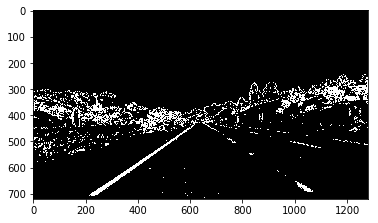

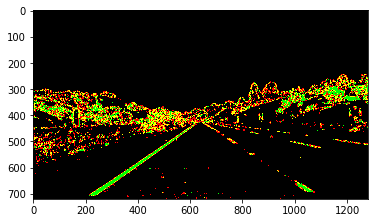

In [15]:
color_binary = thresh_and_binary(corrected_img)
plt.figure(num=1)
plt.imshow(color_binary,cmap='gray')
#plt.imsave("./output_images/binaryImage.png",color_binary,cmap='gray')
a,b,c = test_thresh(corrected_img)
d = np.zeros_like(a)
color_binary2 = np.dstack((a,b,d))*255
plt.figure(num=2)
plt.imshow(color_binary2)


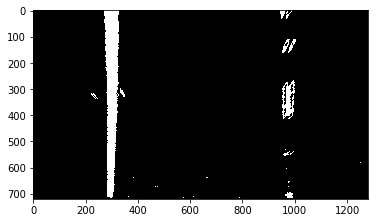

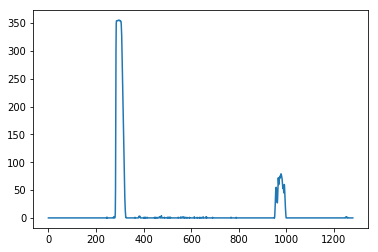

In [16]:
binary_warped = warp(color_binary,M)
plt.figure(num=1)
plt.imshow(binary_warped,cmap='gray')
plt.figure(num=2)
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
histoPlot = plt.plot(histogram)
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:])+midpoint
#print((midpoint,leftx_base,rightx_base))
#plt.imsave('./output_images/birdsEye.png',binary_warped,cmap='gray')
#plt.savefig('./output_images/histogram.png')

In [17]:
def fitLanes(img,nwindows=9,margin=100,minpix=50,visualize=False):
    if(len(img.shape)<3):
        out_img = np.dstack((img,img,img))*255
    else:
        out_img = img
    histogram = np.sum(img[img.shape[0]//2:,:],axis=0)
    midpoint= np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint
    window_height = np.int(img.shape[0]/nwindows)
    #ID x and y posns of all non zero pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if(visualize):
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0,img.shape[0]-1,img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if(visualize):        
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        return (left_fit,right_fit,ploty,left_fitx,right_fitx,out_img)
    return (left_fit,right_fit,ploty,left_fitx,right_fitx)

In [18]:
class Line():
    def __init__(self):
         # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

leftLine = Line()
rightLine = Line()

In [19]:
def Rcurve(fit,ploty,scale=1):
    y_eval = np.max(ploty)
    curveRad = np.around(((1+ (2*fit[0]*y_eval*scale + fit[1])**2)**1.5)/np.absolute(2*fit[0]),1)
    return curveRad
ym_per_pix = 30./720.
xm_per_pix = 3.7/700

In [20]:
def projectLines(warped,ploty,left_fitx,right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    return color_warp

In [21]:
def distFromCentre(left_fit,right_fit,xscale):
    #takes the fit formulas to report the left and right x end pts of the fit lines at the base of the image
    leftx = left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2]
    rightx = right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2]
    laneCentre=rightx-leftx
    #640 pixels is the centre of the image, where the camera is mounted
    #>0 indicates right, <0 indicates left of centre
    return np.around((laneCentre-640)*xscale,3) #convert to metres

0.145


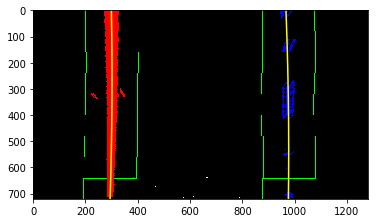

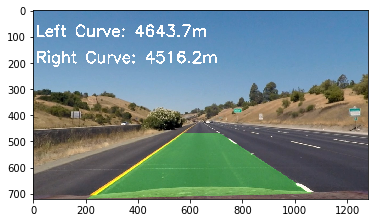

In [22]:
vis_out = np.dstack((binary_warped,binary_warped,binary_warped))*255
lfit,rfit,ploty,leftx,rightx,vis_out = fitLanes(binary_warped,nwindows=9,margin=100,minpix=50,visualize=True)
plt.figure(num=1)
plt.imshow(vis_out)
#plt.imsave('./output_images/windowedFit.png',vis_out)
#print(Rcurve(lfit,ploty)) # in pixels
#print(Rcurve(rfit,ploty))
lfit_cr = np.polyfit(ploty*ym_per_pix,leftx*xm_per_pix,2)
rfit_cr = np.polyfit(ploty*ym_per_pix,rightx*xm_per_pix,2)
leftAngle = "Left Curve: {0}m".format(Rcurve(lfit_cr,ploty,ym_per_pix))
rightAngle = "Right Curve: {0}m".format(Rcurve(rfit_cr,ploty,ym_per_pix))
color_warp = projectLines(binary_warped,ploty,leftx,rightx)
newwarp = warp(color_warp,M_inv,True)
result = cv2.addWeighted(corrected_img,1,newwarp,0.3,0)
cv2.putText(result,leftAngle,(10,100),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),5)
cv2.putText(result,rightAngle,(10,200),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),5)
print(distFromCentre(lfit,rfit,xm_per_pix))
plt.figure(num=2)
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))
plt.imsave('./output_images/processedImage.png',cv2.cvtColor(result,cv2.COLOR_BGR2RGB))

## Outputting the Results

In [23]:
def pipeline(img,nwindows=9,margin=100,minpix=50,xm_per_pix=30/720,ym_per_pix=3.7/700):
    # undistort
    corrected_img = cv2.undistort(img,camParams.mtx,camParams.dist,None,camParams.mtx)
    binary = thresh_and_binary_RGB(corrected_img)
    binary_warped = warp(binary,M)
    lfit,rfit,ploty,leftx,rightx = fitLanes(binary_warped,nwindows,margin,minpix)
    lfit_cr = np.polyfit(ploty*ym_per_pix,leftx*xm_per_pix,2)
    rfit_cr = np.polyfit(ploty*ym_per_pix,rightx*xm_per_pix,2)
    color_warp = projectLines(binary_warped,ploty,leftx,rightx)
    newwarp = warp(color_warp,M_inv,True)
    result = cv2.addWeighted(corrected_img,1,newwarp,0.3,0)
    leftAngle = "Left Curve: {0}m".format(Rcurve(lfit_cr,ploty,ym_per_pix))
    rightAngle = "Right Curve: {0}m".format(Rcurve(rfit_cr,ploty,ym_per_pix))
    dist = distFromCentre(lfit,rfit,xm_per_pix)
    strOut = "Lane Centre:{0} m ".format(abs(dist))
    if(dist<0):
        strOut+="left"
    if(dist>0):
        strOut+="right"
    cv2.putText(result,leftAngle,(10,100),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),5)
    cv2.putText(result,rightAngle,(10,200),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),5)
    cv2.putText(result,strOut,(10,300),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),5)
    return result

In [24]:
def debugPipeline(img,nwindows=9,margin=100,minpix=50,xm_per_pix=30/720,ym_per_pix=3.7/700):
    # undistort
    corrected_img = cv2.undistort(img,camParams.mtx,camParams.dist,None,camParams.mtx)
    binary = thresh_and_binary_RGB(corrected_img)
    binary_warped = warp(binary,M)
    bw = np.dstack((binary_warped,binary_warped,binary_warped))*255
    b = np.dstack((binary,binary,binary))*255
    rightCompare = np.concatenate((bw,b),axis=0)
    rightCompare = cv2.resize(rightCompare,(int(rightCompare.shape[1]/2),int(rightCompare.shape[0]/2)))
    lfit,rfit,ploty,leftx,rightx = fitLanes(binary_warped,nwindows,margin,minpix)
    lfit_cr = np.polyfit(ploty*ym_per_pix,leftx*xm_per_pix,2)
    rfit_cr = np.polyfit(ploty*ym_per_pix,rightx*xm_per_pix,2)
    color_warp = projectLines(binary_warped,ploty,leftx,rightx)
    newwarp = warp(color_warp,M_inv,True)
    result = cv2.addWeighted(corrected_img,1,newwarp,0.3,0)
    leftAngle = "Left Curve: {0}m".format(Rcurve(lfit_cr,ploty,ym_per_pix))
    rightAngle = "Right Curve: {0}m".format(Rcurve(rfit_cr,ploty,ym_per_pix))
    dist = distFromCentre(lfit,rfit,xm_per_pix)
    strOut = "Lane Centre:{0} m ".format(abs(dist))
    if(dist<0):
        strOut+="left"
    if(dist>0):
        strOut+="right"
    cv2.putText(result,leftAngle,(10,100),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),5)
    cv2.putText(result,rightAngle,(10,200),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),5)
    cv2.putText(result,strOut,(10,300),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),5)
    result = np.concatenate((result,rightCompare),axis=1)
    result = cv2.resize(result,(int(result.shape[1]/1.5),int(result.shape[0]/1.5)))
    return result

In [25]:
def dumpImages(img):
    plt.imsave('./debug_images/dump.png',cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    return img    

In [26]:
def generateClip(video,start,end):
    clip1 = VideoFileClip(video).subclip(start,end)
    project_clip = clip1.fl_image(dumpImages)
    #%time clip1.write_videofile('clip.mp4', audio=False)

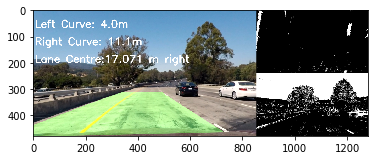

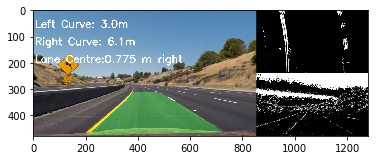

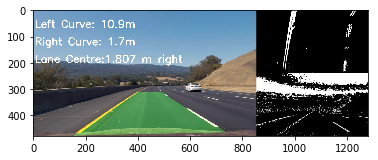

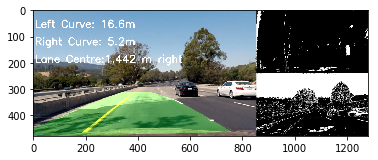

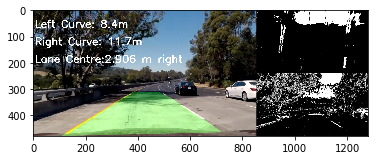

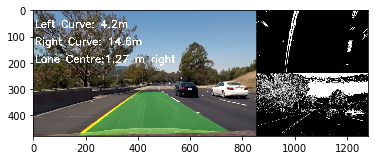

In [27]:
testImages = glob.glob('./test_images/test*.jpg')
i=1
for file in testImages:
    img = cv2.imread(file)
    result = debugPipeline(img,9,100,50)
    plt.figure(num=i)
    plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))
    i+=1

## Video Processing

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [29]:
project_video = 'project_video.mp4'
project_output = 'output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(project_video)
project_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [05:38<00:00,  3.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

Wall time: 5min 39s


In [30]:
project_video = 'project_video.mp4'
count=0
#generateClip(project_video,20,25)

In [ ]:
project_video = 'challenge_video.mp4'
project_output = 'challenge_output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(project_video)
project_clip = clip1.fl_image(debugPipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video challenge_output_video.mp4
[MoviePy] Writing video challenge_output_video.mp4


 69%|███████████████████████████▋            | 336/485 [01:32<00:40,  3.71it/s]